<a href="https://colab.research.google.com/github/nguyenanhtienabcd/AIO2024_EXERCISE/blob/feature%2FMODULE6-WEEK2/m06w02_ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DenseNet Model

### Import thư viện

In [ ]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [ ]:
# cố định giá trị ngẫu nhiên
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

In [ ]:
!gdown 1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639

In [ ]:
!unzip '/content/img_cls_scenes_classification.zip'

### Tiền xử lý dữ liệu

In [ ]:
root_path = '/content/scenes_classification'
train_dir = os.path.join(root_path, 'train')
test_dir = os.path.join(root_path, 'val')
class_labels = {
    idx: class_name for idx, class_name in enumerate(sorted(os.listdir(train_dir)))
    }
print(class_labels)

In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []
for dataset_path in [train_dir, test_dir]:
    for label_index, classname in class_labels.items():
        class_dir = os.path.join(dataset_path, classname)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if 'train' in dataset_path: # kiếm tra xem trong path có từ 'train' không
                x_train.append(img_path)
                y_train.append(label_index)
            else:
                x_test.append(img_path)
                y_test.append(label_index)


In [ ]:
seed = 0
val_train = 0.2
is_shuffle = True
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_train, random_state=seed, shuffle=is_shuffle)


In [ ]:
from torchvision import transforms

class ScenesDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.img_paths = x
        self.labels = y
        # Added a default transform if none is provided
        self.transform = transform if transform is not None else transforms.ToTensor()

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        # Apply the transform to convert PIL Image to PyTorch tensor
        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
train_dataset = ScenesDataset(x_train, y_train, transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
        ]))
val_dataset = ScenesDataset(x_val, y_val, transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
        ]))
test_dataset = ScenesDataset(x_test, y_test, transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
        ]))

In [ ]:
train_batch_size = 32
test_batch_size = 8
num_workers = 2
train_dataloader = DataLoader(train_dataset,
                              batch_size=train_batch_size,
                              num_workers=num_workers,
                              shuffle=True)
val_dataloader = DataLoader(val_dataset,
                            batch_size=test_batch_size,
                            num_workers=num_workers,
                            shuffle=False)
test_dataloader = DataLoader(test_dataset,
                             batch_size=test_batch_size,
                             num_workers=num_workers,
                             shuffle=False)

## Build DenseNet Model

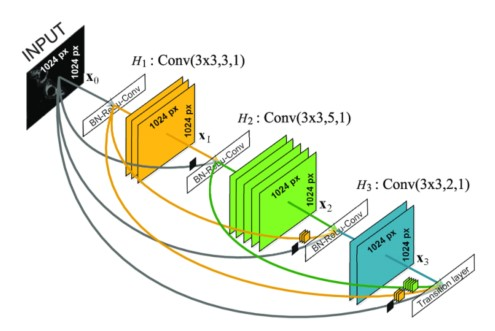

Growth Rate (k) là một tham số rất quan trọng trong kiến trúc DenseNet. Nó xác định số lượng kênh đặc trưng mới mà mỗi lớp trong Dense Block sẽ thêm vào\\

**Tại sao cần Growth Rate (k)?** \\

1. Kiểm soát số lượng tham số: \\
Nếu k quá lớn, số lượng kênh sẽ tăng nhanh qua các lớp, dẫn đến chi phí tính toán cao và yêu cầu bộ nhớ lớn. \\
Nếu k quá nhỏ, mạng có thể không đủ khả năng học các đặc trưng phức tạp. \\

2. Quản lý sự kết hợp giữa thông tin cũ và mới: \\
k đại diện cho mức độ "phát triển" của mỗi lớp: lớp mới không chỉ nhận thông tin từ lớp trước mà còn đóng góp đặc trưng mới vào tổng đầu ra.

Cấu trúc dữ liệu trong PyTorch: Dữ liệu đầu vào cho các mạng CNN thường có kích thước:
$$
(
𝑁
,
𝐶
,
𝐻
,
𝑊
)
$$
Trong đó:

N: Batch size (số mẫu trong batch), \\
C: Số lượng kênh (channels), \\
H: Chiều cao (height) của không gian ảnh, \\
W: Chiều rộng (width) của không gian ảnh. \\
**ví dụ:** ``` out = torch.cat([res, out], 1)``` \\
dim=1 chính là chiều thứ 2 (bắt đầu đếm từ 0), tương ứng với chiều số kênh (channels).

In [ ]:
class BottleneckBlock(nn.Module):
  def __init__(self, in_channels, growth_rate):
    super(BottleneckBlock, self).__init__()
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
    self.bn2 = nn.BatchNorm2d(4 * growth_rate)
    self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
    self.relu = nn.ReLU()

  def forward(self, x):
    res = x.clone().detach()
    out = self.bn1(x)
    out = self.relu(out)
    out = self.conv1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = torch.cat([res, out], 1)
    return out


đầu ra của BottleneckBlock là: \\
$$
out\_channels=in\_channels + growth\_rate
$$
chú ý: ```out = torch.cat([res, out], 1)```


In [ ]:
class DenseBlock(nn.Module):
  def __init__(self, num_layers, in_channels, growth_rate):
    super(DenseBlock, self).__init__()
    layers = []
    for i in range(num_layers):
      layers.append(BottleneckBlock(in_channels + i * growth_rate, growth_rate))
    self.dense_block = nn.Sequential(*layers)

  def forward(self, x):
    return self.dense_block(x)

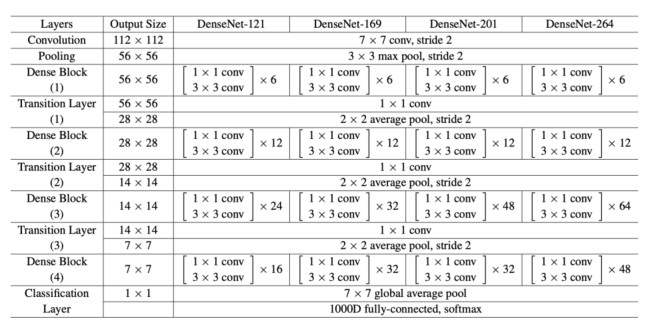

Trong mã của bạn, ```self.dense_blocks``` được sử dụng để lưu trữ một loạt các **Dense Blocks** và **Transition Layers**. \\

**nn.ModuleList đảm bảo rằng:** \\
Tất cả các **Dense Blocks** và **Transition Layers** được lưu trữ trong ```self.dense_blocks``` sẽ được quản lý như một phần của toàn bộ mô hình **DenseNet**.
Tham số của mỗi **Dense Block** hoặc **Transition Layer** sẽ tự động được thêm vào danh sách tham số cần tối ưu hóa khi huấn luyện.
Nếu chỉ sử dụng danh sách Python thông thường ```(list)``` thay vì ```nn.ModuleList```, PyTorch sẽ không nhận biết các lớp này là một phần của mô hình, và bạn sẽ không thể huấn luyện chúng đúng cách.

In [ ]:
class DenseNetBlock(nn.Module):
  def __init__(self, num_blocks, growth_rate, num_classes):
    super(DenseNetBlock, self).__init__()
    # 1
    self.conv1 = nn.Conv2d(3, 2*growth_rate,
                           kernel_size=7, padding=3,
                           stride=2, bias=False)
    self.bn1 = nn.BatchNorm2d(2*growth_rate)
    self.relu = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    #--------------------------------
    self.dense_blocks = nn.ModuleList()
    in_channels = 2*growth_rate
    for i, num_layers in enumerate(num_blocks):
      self.dense_blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
      in_channels += num_layers * growth_rate
      # đoạn code này mục đích là để kiểm tra xem dense_block có phải là node cuối không
      # nếu là node cuối thì không them transition layer nữa
      if i != len(num_blocks) - 1:
        out_channels = in_channels // 2
        self.dense_blocks.append(nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        ))
        in_channels = out_channels
      #--------------------------------

    self.bn2 = nn.BatchNorm2d(in_channels)
    self.relu = nn.ReLU()
    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.fc = nn.Linear(in_channels, num_classes)

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.maxpool1(out)

    for block in self.dense_blocks:
      out = block(out)

    out = self.bn2(out)
    out = self.relu(out)
    out = self.avgpool(out)
    out = out.view(out.size(0), -1)
    out = self.fc(out)

    return out



## Training mô hình

In [ ]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    losses.append(loss)
    _, preds = torch.max(outputs.data, dim = 1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()
  loss = np.mean(losses)
  accuracy = correct/total
  return loss, accuracy

In [ ]:
def fit(model, train_dataloader, data_loader, criterion, optimizer, device, n_epochs):
  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []
  for epoch in range(n_epochs):
    batch_correct = 0
    batch_total = 0
    train_batch_acc = []
    train_batch_losses = []
    model.train()
    for inputs, labels in train_dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      train_batch_losses.append(loss.item())
      loss.backward()
      optimizer.step()

      _, preds = torch.max(outputs.data, dim = 1) # "_" đại diện cho giá trị lớn nhất
      batch_total += labels.size(0)
      batch_correct += (preds == labels).sum().item()

    train_acc = batch_correct/batch_total
    train_loss = np.mean(train_batch_losses)

    train_accs.append(batch_correct/batch_total)
    train_losses.append(np.mean(train_batch_losses))

    val_loss, val_acc = evaluate(model, val_dataloader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch: {epoch+1}:\ Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} --- Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

  return train_losses, train_accs, val_losses, val_accs



In [ ]:
n_classes = len(class_labels.keys())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNetBlock([6, 12, 24, 16],  growth_rate=32, num_classes = n_classes).to(device)

In [ ]:
!pip install torchsummary
from torchsummary import summary

# Remove pretrained argument since it's not used in the forward method
# check = model(torch.randn(1, 3, 224, 224).to(device)) # Pass a dummy input tensor to the model
# The line above was causing the error; we are passing the model itself to summary.
summary(model, (3, 224, 224))

In [ ]:
lr = 1e-2
epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train_losses, train_accs, val_losses, val_accs = fit(model, train_dataloader, val_dataloader, criterion, optimizer, device, epochs)

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,5))

ax[0,0].plot(train_losses, label='train_losses')
ax[0,0].set_title('Training Loss')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Loss')


ax[0,1].plot(val_losses, label='validation_losses', color = 'red')
ax[0,1].set_title('Validation Loss', color = 'red')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Loss')


ax[1,0].plot(train_accs, label='train_accs')
ax[1,0].set_title('Training Accuracy')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Accuracy')

ax[1,1].plot(val_accs, label='validation_accs', color = 'red')
ax[1,1].set_title('Validation Accuracy', color = 'red')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Accuracy')

# Điều chỉnh khoảng cách giữa các ô
plt.tight_layout()

plt.show()